# Zero-Shot Learning Experiments: Latent Embeddings

Using https://joeddav.github.io/blog/2020/05/29/ZSL.html#A-latent-embedding-approach

### 1. Load 5 countries' sentences

In [9]:
import pandas as pd
import sys

sys.path.append("../../")
sys.path.append("../../../")
from tasks.data_loader.src.utils import *

In [222]:
def country_labeled_sentences(excel_map):
    result = {}
    sent_num = 0
    
    for country, dataframe in excel_map.items():

        new_sents_col = dataframe["Sentence"].dropna()
        new_labels_col= dataframe["Primary Instrument"].dropna()
        
        sentences = list(new_sents_col.apply(lambda x: x.replace("\n", "").strip()))
        label_col = new_labels_col.apply(lambda x: x.replace("(PES)", "").replace("(Bond)", "").strip())
        labels = [[string.strip() for string in label.split(", ")][0] for label in label_col]
        result[country] = {}

        for sent, label in zip(sentences, labels):
            if sent_num not in result[country]:
                result[country][sent_num] = {"text": sent, "labels": [label]}
            else:
                result[country][sent_num]["text"] = sent
                result[country][sent_num]["labels"] = [label]
            
            sent_num += 1
            
    return result

def sentences_from_model_output(model_preds):
    return [preds["text"] for preds in model_preds.values()]

In [274]:
data_excel = pd.read_excel("../input/WRI_Policy_Tags.xlsx", engine="openpyxl", sheet_name=None)

In [275]:
all_labeled_sentences = country_labeled_sentences(data_excel)
label_names = ['Credit',
 'Direct payment',
 'Fine',
 'General incentive',
 'Guarantee',
 'Supplies',
 'Tax deduction',
 'Technical assistance',
 'Unknown']

In [276]:
mexico_sents = sentences_from_model_output(all_labeled_sentences['Mexico'])

In [277]:
mexico_labels = labels_from_model_output(all_labeled_sentences['Mexico'])

In [278]:
labeled_sents = dict()

for sents in all_labeled_sentences.values():
    labeled_sents.update(sents)

In [298]:
all_sents = sentences_from_model_output(labeled_sents)
all_labels = labels_from_model_output(labeled_sents)

In [299]:
all_sents[:2], all_labels[:2]

(['Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica',
  'El Programa incentivará a los sujetos agrarios a establecer sistemas productivos agroforestales, el cual combina la producción de los cultivos tradicionales en conjunto con árboles frutícolas y maderables, y el sistema de Milpa Intercalada entre Árboles Frutales (MIAF), con lo que se contribuirá a generar empleos, se incentivará la autosuficiencia alimentaria, se mejorarán los ingresos de las y los pobladores y se recuperará la cobertura forestal de un millón de hectáreas en el país.'],
 ['Technical assistance', 'General incentive'])

### 2. Write out latent embedding algorithm

#### Step 1. Take the top K most frequent words V in the vocabulary of a word2vec model

In [16]:
import spacy
from collections import Counter

In [17]:
en_nlp = spacy.load('en_core_web_md')
es_nlp = spacy.load('es_core_news_md')

In [243]:
sents_as_str = ". ".join(mexico_sents)

In [244]:
doc = es_nlp(sents_as_str)

In [245]:
# all tokens that arent stop words or punctuations
words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]

In [246]:
# 20 most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

In [247]:
top_20_words = list(list(zip(*common_words))[0])

In [248]:
top_20_words

['forestales',
 'forestal',
 'apoyos',
 'manejo',
 'servicios',
 'recursos',
 'programa',
 'desarrollo',
 'ambientales',
 'apoyo',
 'económicos',
 'plantaciones',
 'sustentable',
 'conservación',
 'derecho',
 'promover',
 'actividades',
 'producción',
 'impulsar',
 'incentivos']

#### Step 2. Obtain embeddings for each word using word2vec, $\Phi_{word}(V)$

In [56]:
from sentence_transformers import SentenceTransformer

In [167]:
model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [75]:
word2vec_embeddings = []

for word in top_20_words:
    doc = es_nlp(word)
    vector = doc.vector
    word2vec_embeddings.append(vector.reshape(1, 300))

In [76]:
word2vec_embeddings[5].shape

(1, 300)

#### Step 3. Obtain embeddings for each word using S-BERT, $\Phi_{sent}(V)$

In [77]:
sbert_embeddings = []

for word in top_20_words:
    vector = model.encode([word], convert_to_numpy=True)
    sbert_embeddings.append(vector)

In [78]:
sbert_embeddings[5].shape

(1, 768)

#### Step 4. Learn a least-squares linear projection matrix Z with L2 regularization from $\Phi_{sent}(V)$ to $\Phi_{word}(V)$

In [79]:
import numpy as np

In [92]:
stacked_sbert = np.vstack(sbert_embeddings)
stacked_word2vec = np.vstack(word2vec_embeddings)

In [93]:
stacked_sbert.shape, stacked_word2vec.shape

((20, 768), (20, 300))

In [126]:
# Help from: https://stackoverflow.com/questions/27476933/numpy-linear-regression-with-regularization and https://www.kdnuggets.com/2016/11/linear-regression-least-squares-matrix-multiplication-concise-technical-overview.html
lamda = 0.01
Z = np.linalg.inv(stacked_sbert.T.dot(stacked_sbert) + lamda*np.eye(stacked_sbert.shape[1])).dot(stacked_sbert.T).dot(stacked_word2vec)

In [130]:
Z, Z.shape

(array([[-0.05295929,  0.05582195,  0.05235754, ..., -0.04080104,
          0.04818443, -0.04947441],
        [-0.04507161,  0.04924799,  0.04927182, ...,  0.02818311,
         -0.00224583,  0.01607599],
        [ 0.03529566, -0.01392265,  0.02100322, ...,  0.01322018,
         -0.04029205,  0.00166583],
        ...,
        [-0.02402003,  0.0106964 , -0.01340842, ..., -0.01896193,
          0.02472302,  0.00564555],
        [-0.01577198, -0.039034  , -0.04086349, ..., -0.01778074,
         -0.02431414,  0.00515939],
        [ 0.02128232, -0.02752294, -0.02670326, ...,  0.00878873,
          0.00394322,  0.01953093]]),
 (768, 300))

#### Step 5. Use $Z$ in our classification as an additional transformation to S-BERT embeddings

$$ \hat{c} = arg\,min\,cos(\Phi_{sent}(x)Z, \Phi_{sent}(c)Z)$$

In [151]:
import torch
from torch.nn import functional as F

In [183]:
sentence = 'Quien sera el presidente en 2020?'
labels = ['negocios', 'cultura', 'politica']

In [184]:
sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z)).reshape(1,300)
label_reps = torch.from_numpy(np.matmul(model.encode(labels), Z))

In [185]:
sentence_rep.shape, label_reps.shape

(torch.Size([1, 300]), torch.Size([3, 300]))

In [186]:
similarities = F.cosine_similarity(sentence_rep, label_reps)
closest = similarities.argsort(descending=True)
for ind in closest:
    print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

label: cultura 	 similarity: 0.18005858935166874
label: politica 	 similarity: -0.05537103742702351
label: negocios 	 similarity: -0.13347387625607443


In [187]:
print(closest)

tensor([1, 2, 0])


#### Step 6. Build functions for the process!

In [313]:
def top_k_words(k, document, spacy_model):
    doc = spacy_model(sents_as_str)
    
    # all tokens that arent stop words or punctuations and are longer than 3 letters
    words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 3]
    
    # k most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(k)
    
    return list(list(zip(*common_words))[0])


def top_k_word_embeddings(top_k_words, spacy_model):
    word_embeddings = []

    for word in top_k_words:
        doc = spacy_model(word)
        vector = doc.vector
        word_embeddings.append(vector.reshape(1, vector.shape[0]))
        
    return word_embeddings


def top_k_sbert_embeddings(top_k_words, sbert_model):
    sbert_embeddings = []

    for word in top_k_words:
        vector = sbert_model.encode([word], convert_to_numpy=True)
        sbert_embeddings.append(vector)
    
    return sbert_embeddings


def least_squares_with_reg(X, y, lamda=0.01):
    # Help from: https://stackoverflow.com/questions/27476933/numpy-linear-regression-with-regularization and https://www.kdnuggets.com/2016/11/linear-regression-least-squares-matrix-multiplication-concise-technical-overview.html
    return np.linalg.inv(X.T.dot(X) + lamda*np.eye(X.shape[1])).dot(X.T).dot(y)


def calc_proj_matrix(sentences, k, spacy_model, sbert_model, lamda=0.01):
    sents_as_str = ". ".join(sentences)
    top_words = top_k_words(k, sents_as_str, spacy_model)
    word_emb = np.vstack(top_k_word_embeddings(top_words, spacy_model))
    sent_emb = np.vstack(top_k_sbert_embeddings(top_words, sbert_model))
    proj_matrix = least_squares_with_reg(sent_emb, word_emb, lamda)
    
    return proj_matrix

def classify_sentence(sentence, labels, model, Z):
    sentence_rep = torch.from_numpy(np.matmul(model.encode(sentence), Z))
    sentence_rep = sentence_rep.reshape(1, sentence_rep.shape[0])
    label_reps = torch.from_numpy(np.matmul(model.encode(labels), Z))
    
    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)
    
    top_index = closest[0]
    return labels[top_index], similarities[top_index]

def classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix):
    model_preds, model_scores = [], []

    for sent in tqdm(all_sents):
        pred, score = classify_sentence(sent, label_names, sbert_model, proj_matrix)
        model_preds.append(pred)
        model_scores.append(score)
        
    return model_preds, model_scores

#### Step 7. Time to play on our data!

In [197]:
from tqdm import tqdm
from tasks.evaluate_model.src.model_evaluator import *

In [191]:
sbert_model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [200]:
model_preds, model_scores = [], []

for mexico_sent in tqdm(mexico_sents):
    pred, score = classify_sentence(mexico_sent, label_names, sbert_model, Z)
    model_preds.append(pred)
    model_scores.append(score)

100%|██████████| 211/211 [01:10<00:00,  3.00it/s]


In [202]:
evaluator = ModelEvaluator(label_names)

In [203]:
num_multi_labels = labels_to_numeric(mexico_labels, label_names)
num_multi_preds = labels_to_numeric(model_preds, label_names)

In [204]:
num_multi_labels[:10], num_multi_preds[:10]

([7, 3, 5, 7, 1, 1, 5, 3, 7, 7], [6, 6, 5, 7, 6, 5, 6, 6, 4, 7])

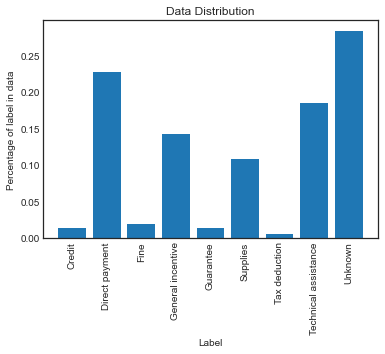

Label counts:
{'Credit': 0.014218009478672985, 'Direct payment': 0.22748815165876776, 'Fine': 0.018957345971563982, 'General incentive': 0.14218009478672985, 'Guarantee': 0.014218009478672985, 'Supplies': 0.10900473933649289, 'Tax deduction': 0.004739336492890996, 'Technical assistance': 0.1848341232227488, 'Unknown': 0.2843601895734597}


In [207]:
plot_data_distribution(num_multi_labels, label_names)

/Users/dafirebanks/miniconda3/envs/wri_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/multi_class_test_cm.png


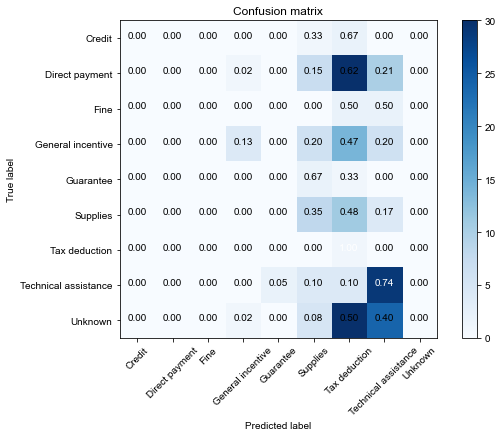

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Credit,0,0,1,0
Direct payment,0,0,1,0
Fine,0,0,1,0
General incentive,0.67,0.13,0.99,0.22
Guarantee,0,0,0.99,0
Supplies,0.24,0.35,0.87,0.29
-----,-----,-----,-----,-----
Tax deduction,0.01,1,0.55,0.02
Technical assistance,0.39,0.74,0.73,0.51
Unknown,0,0,1,0


In [205]:
evaluator.evaluate(num_multi_labels, num_multi_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: multi_class_test_prc.png


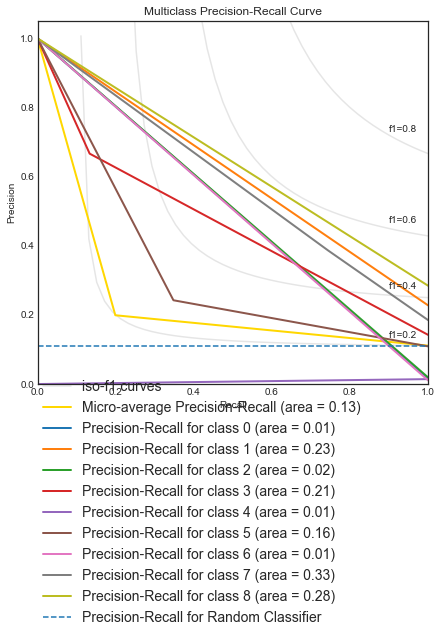

In [206]:
evaluator.plot_precision_recall_curve(num_multi_labels, num_multi_preds, bin_class=False, all_classes=True, store=True, exp_name="multi_class_test")

## Further Experiments

### Things to play around with
- mix credit and guarantee together, replace unknown with something else?
- lamda for projection matrix
- k for top k words
- model type for sentence embeddings
- model type for word embeddings?
- fine tuning sentence model

### Experiment 1. Mix credit and guarantee

In [300]:
all_labels = ["Credit & Guarantee" if label == "Credit" or label == "Guarantee" else label for label in all_labels]

In [302]:
label_names = list(set(all_labels))

In [294]:
# Setup - Get projection matrix
proj_matrix = calc_proj_matrix(all_sents, 50, es_nlp, sbert_model, 0.1)

In [307]:
# Actual classification
model_preds, model_scores = classify_all_sentences(all_sents, label_names, sbert_model, proj_matrix)

100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


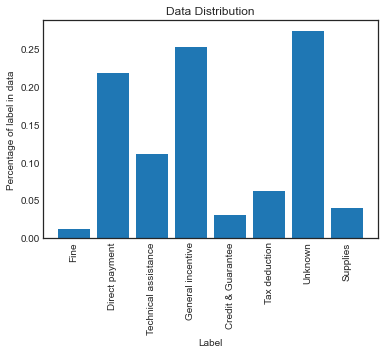

Label counts:
{'Fine': 0.0121765601217656, 'Direct payment': 0.2176560121765601, 'Technical assistance': 0.1111111111111111, 'General incentive': 0.2526636225266362, 'Credit & Guarantee': 0.030441400304414, 'Tax deduction': 0.0624048706240487, 'Unknown': 0.273972602739726, 'Supplies': 0.0395738203957382}


In [308]:
# Post processing
num_labels = labels_to_numeric(all_labels, label_names)
num_preds = labels_to_numeric(model_preds, label_names)

plot_data_distribution(num_labels, label_names)

In [310]:
evaluator = ModelEvaluator(label_names)

/Users/dafirebanks/miniconda3/envs/wri_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: ../output/latent_emb_test_cm.png


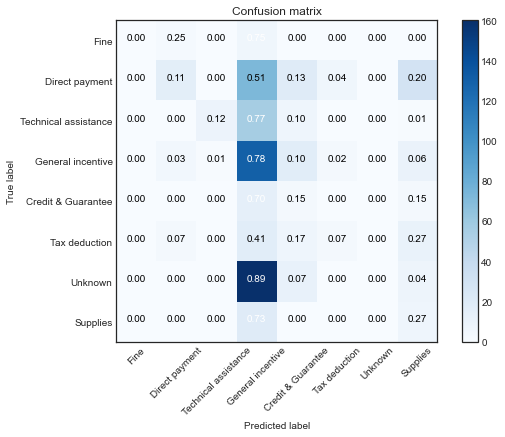

Stored results: ../output/latent_emb_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Fine,0,0,1,0
Direct payment,0.62,0.11,0.98,0.19
Technical assistance,0.9,0.12,1,0.22
General incentive,0.27,0.78,0.3,0.41
Credit & Guarantee,0.05,0.15,0.9,0.07
Tax deduction,0.25,0.07,0.99,0.11
-----,-----,-----,-----,-----
Unknown,0,0,1,0
Supplies,0.1,0.27,0.9,0.15
Macro avg,0.27,0.19,0.88,0.14


In [311]:
evaluator.evaluate(num_labels, num_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="latent_emb_test")

/Users/dafirebanks/miniconda3/envs/wri_env/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Stored Precision-Recall Curve: latent_emb_test_prc.png


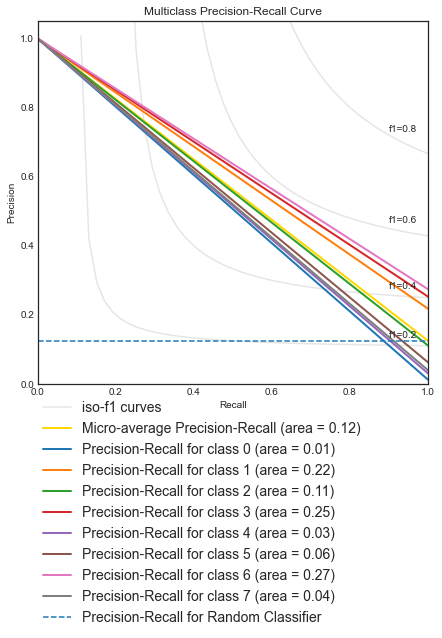

In [312]:
evaluator.plot_precision_recall_curve(num_labels, model_preds, bin_class=False, all_classes=True, store=True, exp_name="latent_emb_test")